[Code](https://gist.github.com/sergiosonline/6a3e0b1345c8f002d0e7b11aaf252d44)
for
[Painless Introduction to Applied Bayesian Inference using (Py)Stan](https://towardsdatascience.com/painless-introduction-to-applied-bayesian-inference-using-py-stan-36b503a4cd80).

In [1]:
import pystan
import pickle
import numpy as np
import arviz as az
import pandas as pd
import seaborn as sns
import statsmodels.api as statmod
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 

# Bayesian Inference - Estimate $\theta$ from Bernoulli observations

$$
\theta \sim \text{beta}(a,b)\\
Y \sim \text{bernoulli}(\theta)
$$

$$
P(Y=y|\theta) = \theta^{y} (1-\theta)^{1-y},\\ \text{where } Y \in \{0,1\}, \theta \in [0,1]
$$

$$
P(\theta|Y) \approx \frac{\prod^{K}P(Y=y_{i}|\theta) P(\theta)}{C}
$$

Recall that $y \sim \text{Bernoulli}(\theta)$ is equivalent to
$$
P(Y=y|\theta) = \theta^{y} (1-\theta)^{1-y},\\ \text{where } Y \in \{0,1\}, \theta \in [0,1]
$$

Imagine we have an arbitrary coin and we would like to determine whether it is fair ($\theta$ = 50%) or not. For this problem, we observe a sample of Y's (1 indicates heads, while 0 indicates tails).

We experiment by flipping this coin K number of times. We would like to estimate $\theta$, i.e., the probability that we obtain heads for a given toss.

If we tackle this problem from the frequentist perspective, we can easily devise the maximum likelihood estimator for $\theta$ as 
$$\hat{\theta}_{ML} = \sum_{i}^{K}\frac{y_{i}}{K},$$ where $K$ corresponds to the number of trials/observations in our experiment.

Say we flip the coin **4** times and, by struck of luck (or lack thereof), we observe **all** tails. Then, 

$$\hat{\theta}_{ML} = \sum_{i}^{4}\frac{y_{i}}{4}=0$$

which is quite extreme, for, having two sides, there is **SOME** probability that we can observe heads in the next trial.

#### Applied Bayesian inference

We can adopt a more 'scientific' approach by expressing our prior belief about this coin. Say I believe the coin is most likely to be fair, but I believe there to be a (possibly smaller) chance that it is not.

Then I can establish the following prior probability on $\theta$:
$$
\theta \sim \text{beta}(5,5)
$$

This prior makes sense because $\forall \alpha, \beta \in \mathcal{R}^+, \text{ beta}(\alpha,\beta) \in [0,1]$, namely, $\theta$ is a probability and **cannot** be less than 0 or greater than 1.

Let's visualize this prior by sampling from it:

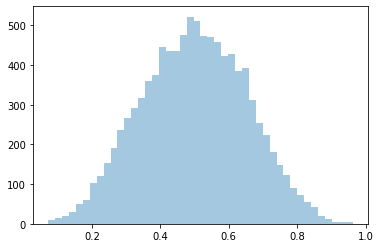

In [2]:
sns.distplot(np.random.beta(5,5, size=10000),kde=False);

In [3]:
# bernoulli model

data = dict(N=4, y=[0, 0, 0, 0])

model_code = """
    data {
      int<lower=0> N;
      int<lower=0,upper=1> y[N];
    }
    parameters {
      real<lower=0,upper=1> theta;
    }
    model {
      theta ~ beta(5, 5);
      for (n in 1:N)
          y[n] ~ bernoulli(theta);
    }
    """

In [4]:
model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d3835c4370ff5e66f1e88bd3eac647ff NOW.


In [5]:
fit = model.sampling(data=data,iter=4000, chains=4, warmup=1000)
# Default params for sampling() are iter=1000, chains=4, warmup=500

In [6]:
la = fit.extract(permuted=True)  # return a dictionary of arrays

In [7]:
print(fit.stansummary())

Inference for Stan model: anon_model_d3835c4370ff5e66f1e88bd3eac647ff.
4 chains, each with iter=4000; warmup=1000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=12000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta   0.35  1.8e-3   0.12   0.14   0.26   0.35   0.43    0.6   4395    1.0
lp__   -9.63  9.9e-3   0.72 -11.65   -9.8  -9.36  -9.17  -9.13   5262    1.0

Samples were drawn using NUTS at Sun Aug 30 04:06:51 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


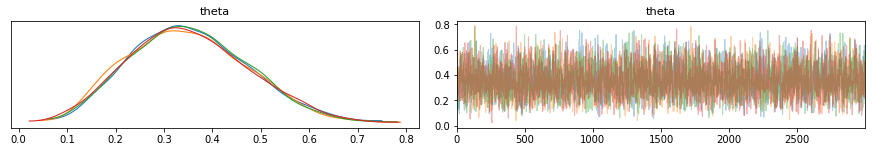

In [8]:
ax = az.plot_trace(fit, var_names=["theta"])

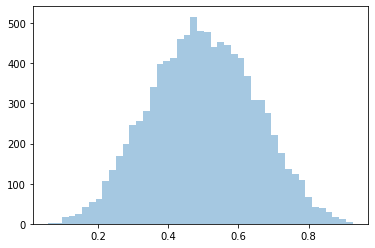

In [9]:
sns.distplot(np.random.beta(5,5, size=10000),kde=False);

$$
\begin{align}
P(\theta|D)&=\frac{P(D|\theta)P(\theta)}{P(D)} \\
    &\propto P(D|\theta)P(\theta)
\end{align}
$$

$$
P(D) = \int P(D|\theta)P(\theta)d\theta
$$

# Bayesian Regression - Car MPG Problem

Our dataset comes from [here](https://archive.ics.uci.edu/ml/datasets/auto+mpg)

Predict/estimate `mpg` based on available features:
* `weight`
* `year`
* `cylinders`
* `hp`
* `acceleration`
* `displacement`
* `origin`

In [10]:
Image(url= "https://external-preview.redd.it/fCEkl9G2WE3sw6VHYU8TM1J5K7zgmvECNWv__srdML0.jpg?auto=webp&s=5b8973a18dea7d517229b6dca1123c354bbe7603")

Let's start with the regression equation for it shall inform how we think of our models, both as a maximum-likelihood curve-fitting problem and Bayesian generative modelling problem:

$$
Y = X\beta + \epsilon \\
\text{where } \epsilon \sim \text{MVN}(0,\Sigma)
$$

Note that the only random quantity in our equation above is $\epsilon$.


In [11]:
# Load the data
cars_data = pd.read_csv("../data/cars.csv.gz")
print(cars_data.shape)
cars_data.head()

(398, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [12]:
for col_name in cars_data.columns[1:]:
    print(cars_data[col_name].value_counts().head())

4    204
8    103
6     84
3      4
5      3
Name: cylinders, dtype: int64
97.0     21
98.0     18
350.0    18
250.0    17
318.0    17
Name: displacement, dtype: int64
150.0    22
90.00    20
88.00    19
110.0    18
100.0    17
Name: horsepower, dtype: int64
2130.0    4
1985.0    4
2265.0    3
2125.0    3
2720.0    3
Name: weight, dtype: int64
14.5    23
15.5    21
16.0    16
14.0    16
13.5    15
Name: acceleration, dtype: int64
73    40
78    36
76    34
82    31
75    30
Name: model year, dtype: int64
1    249
3     79
2     70
Name: origin, dtype: int64
ford pinto        6
ford maverick     5
amc matador       5
toyota corolla    5
amc hornet        4
Name: car name, dtype: int64


In [13]:
cars_data.loc[cars_data['origin']==1, 'origin'] = 'American'
cars_data.loc[cars_data['origin']==2, 'origin'] = 'European'
cars_data.loc[cars_data['origin']==3, 'origin'] = 'Japanese'

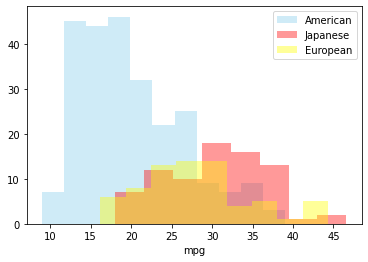

In [14]:
sns.distplot(cars_data[cars_data['origin']=='American']['mpg'],color="skyblue", label="American",kde=False)
sns.distplot(cars_data[cars_data['origin']=='Japanese']['mpg'],color="red", label="Japanese",kde=False)
sns.distplot(cars_data[cars_data['origin']=='European']['mpg'],color="yellow", label="European",kde=False)
plt.legend();

/usr/local/lib/python3.7/site-packages/seaborn/relational.py:1651: UserWarning: relplot is a figure-level function and does not accept target axes. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/seaborn/relational.py:1651: UserWarning: relplot is a figure-level function and does not accept target axes. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/seaborn/relational.py:1651: UserWarning: relplot is a figure-level function and does not accept target axes. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/seaborn/relational.py:1651: UserWarning: relplot is a figure-level function and does not accept target axes. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/seaborn/relational.py:1651: UserWarning: relplot is a figure-level function and does not accept target ax

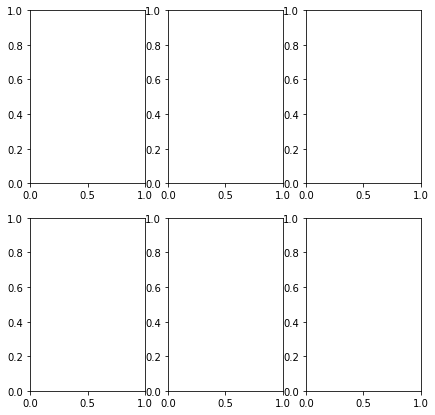

In [15]:
f, axes = plt.subplots(2, 3, figsize=(7, 7), sharex=False)

sns.relplot(x="cylinders", y="mpg", data=cars_data, ax=axes[0, 0]);
sns.relplot(x="displacement", y="mpg", data=cars_data, ax=axes[0, 1]);
sns.relplot(x="horsepower", y="mpg", data=cars_data, ax=axes[0, 2]);
sns.relplot(x="acceleration", y="mpg", data=cars_data, ax=axes[1, 0]);
sns.relplot(x="model year", y="mpg", data=cars_data, ax=axes[1, 1]);
sns.relplot(x="weight", y="mpg", data=cars_data, ax=axes[1, 2]);

# close pesky empty plots
for num in range(2,8):
    plt.close(num);
    
plt.show();

### Maximum Likelihood OLS Regression

In [16]:
from numpy import random
from sklearn import preprocessing, metrics, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

random.seed(12345)

cars_data_vars = cars_data.columns.values[:-1].tolist()

In [17]:
y = cars_data['mpg']
X = cars_data.loc[:, cars_data.columns != 'mpg']
X = X.loc[:, X.columns != 'name']
X = pd.get_dummies(X, prefix_sep='_', drop_first=False)
X = X.drop(columns=["origin_Japanese"])  # 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

X_train.head()

,cylinders,displacement,weight,acceleration,model year,horsepower_100.0,horsepower_102.0,horsepower_103.0,horsepower_105.0,horsepower_107.0,...,car name_volvo 145e (sw),car name_volvo 244dl,car name_volvo 245,car name_volvo 264gl,car name_volvo diesel,car name_vw dasher (diesel),car name_vw pickup,car name_vw rabbit,car name_vw rabbit c (diesel),car name_vw rabbit custom
200,6,250.0,3574.0,21.0,76,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
206,4,140.0,2565.0,13.6,76,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107,6,232.0,2789.0,15.0,73,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,6,198.0,2833.0,15.5,70,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106,8,350.0,4499.0,12.5,73,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Fit and summarize OLS model
X_train['const'] = 1; X_test['const'] = 1
#X_train = X_train.drop(columns=['origin_American'])
mod1 = statmod.OLS(y_train, X_train, prepend=False)
res = mod1.fit()
print(res.summary())

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     14.52
Date:                Sun, 30 Aug 2020   Prob (F-statistic):           7.94e-10
Time:                        04:06:53   Log-Likelihood:                -267.68
No. Observations:                 338   AIC:                             1167.
Df Residuals:                      22   BIC:                             2375.
Df Model:                         315                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [19]:
y_train_freq = res.predict(X_train)
y_train_freq.head()

200    18.000000
206    25.835364
107    18.140901
15     20.925215
106    12.000000
dtype: float64

In [20]:
y_test_freq = res.predict(X_test)
y_test_freq.head()

65     15.105187
132    24.924463
74     13.499367
78     15.557902
37     17.510322
dtype: float64

Freq Train MSE: 0.2853629163337806


/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


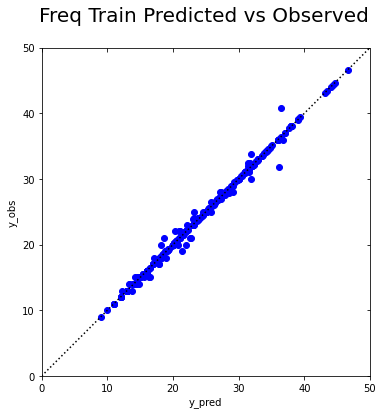

In [21]:
freq_train_mse = metrics.mean_squared_error(y_train, y_train_freq)
print('Freq Train MSE:', freq_train_mse)
dff = pd.DataFrame({'y_pred':y_train_freq, 'y_obs':y_train})
grid = sns.JointGrid(dff.y_pred, dff.y_obs, space=0, height=6, ratio=50,
                    xlim=(0,50), ylim=(0,50))
grid.plot_joint(plt.scatter, color="b")
x0, x1 = grid.ax_joint.get_xlim()
y0, y1 = grid.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
grid.ax_joint.plot(lims, lims, ':k')
plt.subplots_adjust(top=0.9)
grid.fig.suptitle('Freq Train Predicted vs Observed',fontsize=20)
plt.show()

Freq Test MSE: 23.508292279662296


/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


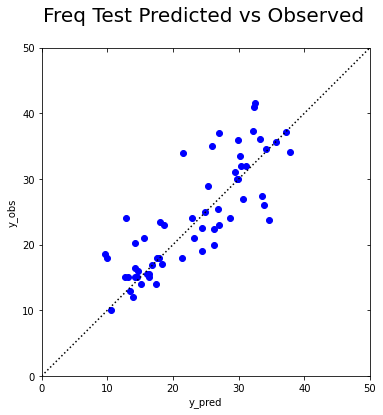

In [22]:
freq_test_mse = metrics.mean_squared_error(y_test, y_test_freq)
print('Freq Test MSE:', freq_test_mse)
dff = pd.DataFrame({'y_pred':y_test_freq, 'y_obs':y_test})
grid = sns.JointGrid(dff.y_pred, dff.y_obs, space=0, height=6, ratio=50,
                    xlim=(0,50), ylim=(0,50))
grid.plot_joint(plt.scatter, color="b")
x0, x1 = grid.ax_joint.get_xlim()
y0, y1 = grid.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
grid.ax_joint.plot(lims, lims, ':k')
plt.subplots_adjust(top=0.9)
grid.fig.suptitle('Freq Test Predicted vs Observed',fontsize=20)
plt.show()

### Bayesian OLS Regression

Now let's examine the Bayesian formulation of our regression problem:

$$
Y = X\beta + \epsilon \\
\text{where } \epsilon \sim \text{MVN}(0,\Sigma) \\
\beta \sim P \\
\sigma \sim Q
$$

Recall the expression to evaluate the Bayesian posterior of the model parameters:

$$
P(\theta|D) \propto P(D|\theta)P(\theta)
$$

For our inference we are interested in obtaining posterior distributions for $\beta$ and $\sigma$.

Once we obtain an approximation of the posterior $P(\theta|D)$, we can actually compute a predictive posterior to fit an unseen/test vector of data points $X_{\text{new}}$:

$$
P(X_{new}|D_{old}) = \int{P(X_{new}|\theta,D_{old})P(\theta|D_{old})}\,d\theta
$$


In [23]:
from numpy import random
from sklearn import preprocessing, metrics, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

random.seed(12345)

y = cars_data['mpg']
X = cars_data.loc[:, cars_data.columns != 'mpg']
X = X.loc[:, X.columns != 'name']
X = pd.get_dummies(X, prefix_sep='_', drop_first=False)
X = X.drop(columns=["origin_European"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

In [24]:
X_train.head()

,cylinders,displacement,weight,acceleration,model year,horsepower_100.0,horsepower_102.0,horsepower_103.0,horsepower_105.0,horsepower_107.0,...,car name_volvo 145e (sw),car name_volvo 244dl,car name_volvo 245,car name_volvo 264gl,car name_volvo diesel,car name_vw dasher (diesel),car name_vw pickup,car name_vw rabbit,car name_vw rabbit c (diesel),car name_vw rabbit custom
200,6,250.0,3574.0,21.0,76,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
206,4,140.0,2565.0,13.6,76,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107,6,232.0,2789.0,15.0,73,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,6,198.0,2833.0,15.5,70,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106,8,350.0,4499.0,12.5,73,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Succint matrix notation

cars_code = """
data {
    int<lower=1> N; // number of training samples
    int<lower=0> K; // number of predictors
    matrix[N, K] x; // matrix of predictors
    vector[N] y_obs; // observed/training mpg
    
    int<lower=1> N_new;
    matrix[N_new, K] x_new;
}
parameters {
    real alpha;
    vector[K] beta;
    //vector[K] tau;
    real<lower=0> sigma;
    
    vector[N_new] y_new;
}
transformed parameters {
    vector[N] theta;
    theta = alpha + x * beta;
}
model {
    sigma ~ exponential(1);
    alpha ~ normal(0, 6);
    beta ~ multi_normal(rep_vector(0, K), diag_matrix(rep_vector(1, K)));
    y_obs ~ normal(theta, sigma);
    
    y_new ~ normal(alpha + x_new * beta, sigma); // prediction model
}
"""

In [26]:
cars_dat = {'N': X_train.shape[0],
            'N_new': X_test.shape[0],
            'K': X_train.shape[1],
            'y_obs': y_train.values.tolist(),
            'x': np.array(X_train),
            'x_new': np.array(X_test)}

In [27]:
sm = pystan.StanModel(model_code=cars_code, verbose=True)  # FIXME: SET VERBOSE TO FALSE.

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3112a6cce1c41eead6e39aa4b53ccc8b NOW.
INFO:pystan:OS: linux, Python: 3.7.9 (default, Aug 18 2020, 03:27:13) 
[GCC 8.3.0], Cython 0.29.21


Compiling /tmp/pystan_k703t2xz/stanfit4anon_model_3112a6cce1c41eead6e39aa4b53ccc8b_8724641729494787198.pyx because it changed.
[1/1] Cythonizing /tmp/pystan_k703t2xz/stanfit4anon_model_3112a6cce1c41eead6e39aa4b53ccc8b_8724641729494787198.pyx
building 'stanfit4anon_model_3112a6cce1c41eead6e39aa4b53ccc8b_8724641729494787198' extension
creating /tmp/pystan_k703t2xz/tmp
creating /tmp/pystan_k703t2xz/tmp/pystan_k703t2xz
gcc-8 -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/pystan_k703t2xz -I/usr/local/lib/python3.7/site-packages/pystan -I/usr/local/lib/python3.7/site-packages/pystan/stan/src -I/usr/local/lib/python3.7/site-packages/pystan/stan/lib/stan_math -I/usr/local/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3 -I/usr/local/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0 -I/usr/local/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/su

In [28]:
# fit = sm.sampling(data=cars_dat, iter=6000, chains=8, n_jobs=1)  # FIXME: SET N_JOBS BACK TO -1.
# Took 14 hours.

In [ ]:
fit = sm.sampling(data=cars_dat, iter=6000, chains=8)
# Took 4.5 hours.

In [29]:
la = fit.extract(permuted=True)
print(fit.stansummary())

Inference for Stan model: anon_model_3112a6cce1c41eead6e39aa4b53ccc8b.
8 chains, each with iter=6000; warmup=3000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=24000.

              mean se_mean     sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
alpha       -10.65    0.02   3.48  -17.49  -13.01  -10.67   -8.29   -3.78  28557    1.0
beta[1]      -0.45  1.9e-3   0.33    -1.1   -0.67   -0.45   -0.23    0.19  30404    1.0
beta[2]       0.01  4.8e-5 7.8e-3 -1.8e-3  8.1e-3    0.01    0.02    0.03  26368    1.0
beta[3]    -6.4e-3  3.7e-6 6.3e-4 -7.6e-3 -6.8e-3 -6.4e-3 -6.0e-3 -5.2e-3  28525    1.0
beta[4]       0.16  4.5e-4   0.08  2.5e-3    0.11    0.16    0.22    0.33  34509    1.0
beta[5]       0.68  2.7e-4   0.05    0.59    0.65    0.68    0.71    0.77  27385    1.0
beta[6]      -0.87  3.0e-3   0.65   -2.15    -1.3   -0.87   -0.44    0.41  46836    1.0
beta[7]       -0.3  3.9e-3   0.96   -2.17   -0.95    -0.3    0.35    1.58  59395    1.0
beta[8]      -0.56

In [30]:
post_data = az.convert_to_dataset(fit)

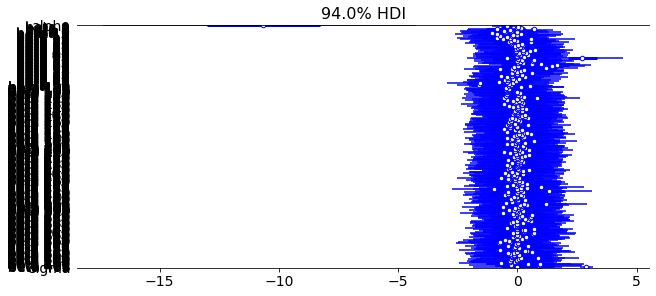

In [31]:
# Let's examine the posterior distribution of our model parameters
axes = az.plot_forest(
    post_data,
    kind="forestplot",
    var_names= ["alpha","beta","sigma"],
    combined=True,
    ridgeplot_overlap=1.5,
    colors="blue",
    figsize=(9, 4),
)


# Print out some MC diagnostic plots (trace/mixing plots, etc)

/usr/local/lib/python3.7/site-packages/arviz/plots/traceplot.py:254: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (408), generating only 20 plots
  UserWarning,


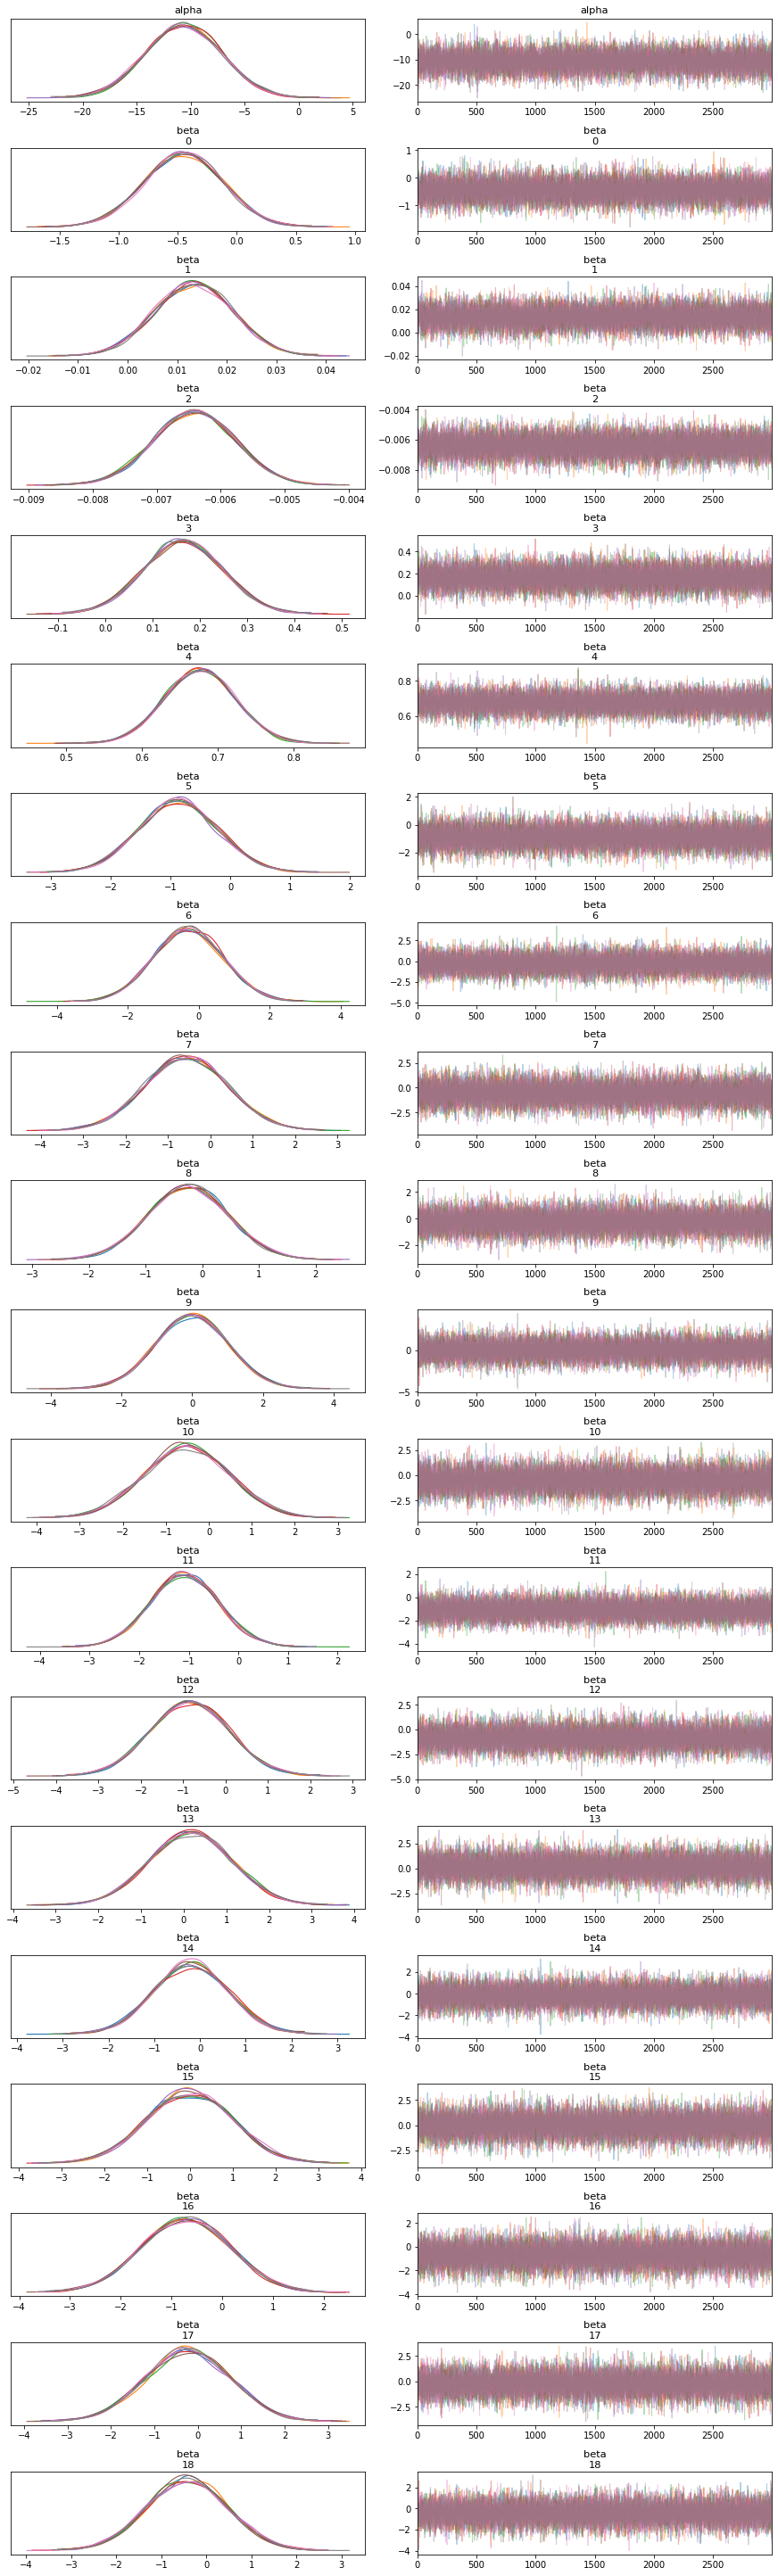

In [32]:
ax = az.plot_trace(fit, var_names=["alpha","beta","sigma"])
# Great mixing: The thicker the better

Bayes Train MSE: 6.976424771883434


/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


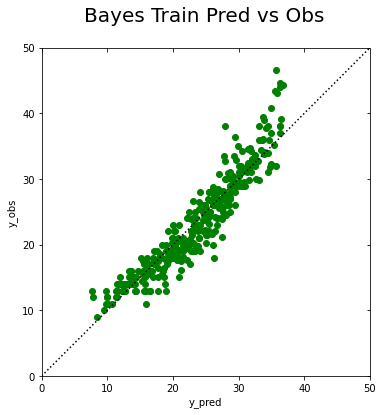

In [33]:
bay_train_mse = metrics.mean_squared_error(y_train.values, fit['theta'].mean(0))
print('Bayes Train MSE:', bay_train_mse)
dff = pd.DataFrame({'y_pred':fit['theta'].mean(0), 'y_obs':y_train.values})
grid = sns.JointGrid(dff.y_pred, dff.y_obs, space=0, height=6, ratio=50,
                    xlim=(0,50), ylim=(0,50))
grid.plot_joint(plt.scatter, color="g")
x0, x1 = grid.ax_joint.get_xlim()
y0, y1 = grid.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
grid.ax_joint.plot(lims, lims, ':k')
plt.subplots_adjust(top=0.9)
grid.fig.suptitle('Bayes Train Pred vs Obs',fontsize=20)
plt.show()

Bayes Test MSE: 10.28492358858415


/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


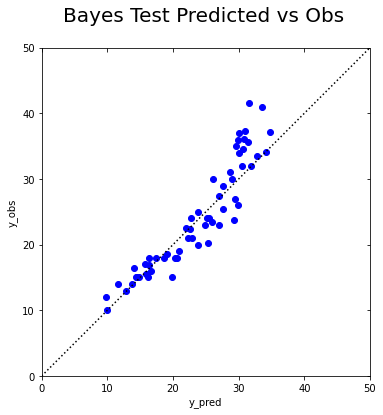

In [34]:
bay_test_mse = metrics.mean_squared_error(y_test, la['y_new'].mean(0))
print('Bayes Test MSE:', bay_test_mse)
dff = pd.DataFrame({'y_pred':la['y_new'].mean(0), 'y_obs':y_test})
grid = sns.JointGrid(dff.y_pred, dff.y_obs, space=0, height=6, ratio=50,
                    xlim=(0,50), ylim=(0,50))
grid.plot_joint(plt.scatter, color="b")
x0, x1 = grid.ax_joint.get_xlim()
y0, y1 = grid.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
grid.ax_joint.plot(lims, lims, ':k')  

plt.subplots_adjust(top=0.9)
grid.fig.suptitle('Bayes Test Predicted vs Obs',fontsize=20)
plt.show()

# Visualize the value of the prediction as we vary some model inputs, along with the prediction 95% confidence bands

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:382: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()
/usr/local/lib/python3.7/site-packages/arviz/stats/stats.py:486: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


<AxesSubplot:>

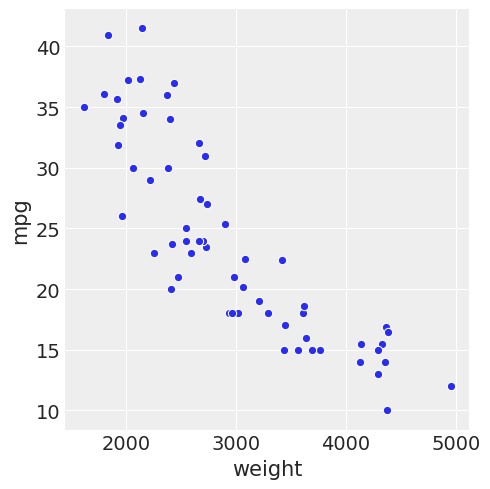

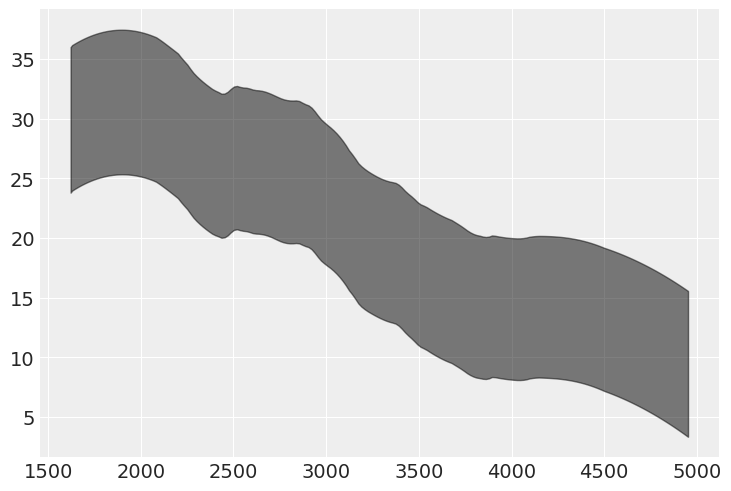

In [35]:
import matplotlib.pyplot as plt
import weakref
az.style.use("arviz-darkgrid")

sns.relplot(x="weight", y="mpg",
            data=pd.DataFrame({'weight':X_test['weight'],'mpg':y_test}))
az.plot_hpd(X_test['weight'], la['y_new'], color="k", plot_kwargs={"ls": "--"})

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:382: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()
/usr/local/lib/python3.7/site-packages/arviz/stats/stats.py:486: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


<AxesSubplot:>

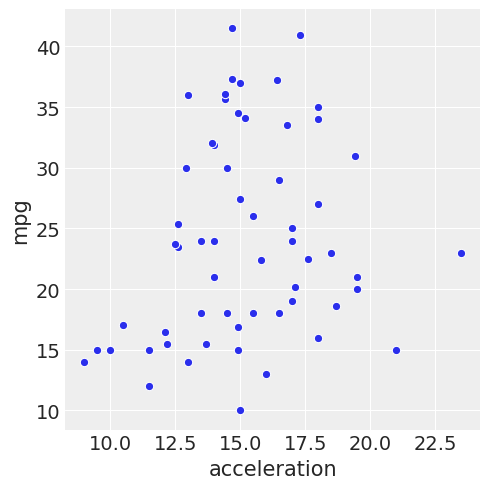

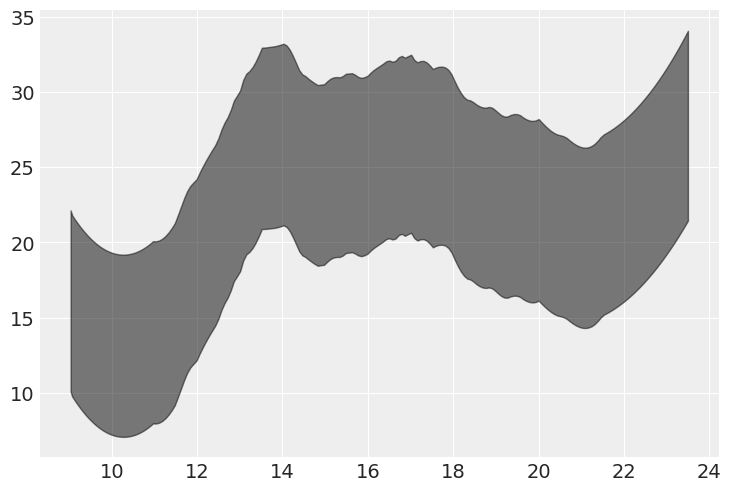

In [36]:
sns.relplot(x="acceleration", y="mpg",
            data=pd.DataFrame({'acceleration':X_test['acceleration'],'mpg':y_test}))
az.plot_hpd(X_test['acceleration'], la['y_new'], color="k", plot_kwargs={"ls": "--"})

In [37]:
print('Freq Train MSE:', freq_train_mse)
print('Freq Test MSE:', freq_test_mse)
print('Bayes Train MSE:', bay_train_mse)
print('Bayes Test MSE:', bay_test_mse)

Freq Train MSE: 0.2853629163337806
Freq Test MSE: 23.508292279662296
Bayes Train MSE: 6.976424771883434
Bayes Test MSE: 10.28492358858415



<table>
  <tr>
    <th></th>
    <th>Train MSE</th>
    <th>Test MSE</th> 
  </tr>
  <tr>
    <td><b>Bayesian</b></td>
    <td>10.829</td> 
    <td>10.968</td> 
  </tr>
  <tr>
    <td><b>Frequentist / MLE</b></td>
    <td>10.747</td> 
    <td>10.558</td> 
</table>
